In [1]:
import os
from pathlib import Path
from operator import itemgetter
import pickle
import pydicom
import pandas
from time import time

import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Polygon, MultiPolygon, LineString, GeometryCollection, Point, MultiPoint
from shapely.affinity import translate

from catch_converter.parse_contours import parse_cvi42ws
from LazyLuna.Mini_LL import *
from LazyLuna.CATCH_utils import *
from LazyLuna.network_comparison_utils import *

In [2]:
# basepaths
"""
bp       = '/media/omega/Daten1/CATCH/CS'
bp_annos = '/media/omega/Daten1/CATCH/CS/Preds/FCN'
bp_cases = '/media/omega/Daten1/CATCH/CS/Cases'
bp_imgs  = '/media/omega/Daten1/CATCH/CS/Imgs'
"""
bp       = '/Users/dietrichhadler/Desktop/Daten/CS_ESED_Cases'
bp_annos = '/Users/dietrichhadler/Desktop/Daten/CS_ESED_Cases/Annos'
bp_cases = '/Users/dietrichhadler/Desktop/Daten/CS_ESED_Cases/Cases'
bp_imgs  = '/Users/dietrichhadler/Desktop/Daten/CS_ESED_Cases/Imgs'


In [3]:
"""
imgsanno_paths = get_imgs_and_annotation_paths(bp_imgs, bp_annos)
imgsanno_paths = [p for p in imgsanno_paths if os.path.exists(p[1])]

cases = []
sax_cs_view   = SAX_CS_View()
for imgp, annop in imgsanno_paths:
    print(imgp, annop)
    st = time()
    case = Case(imgp, annop, os.path.basename(imgp), os.path.basename(bp_annos))
    case = sax_cs_view.customize_case(case)
    case.store(bp_cases)
    cases.append(case)
    print('Case customization took: ', time()-st, 'Case: ', case.reader_name, case.case_name)
"""

"\nimgsanno_paths = get_imgs_and_annotation_paths(bp_imgs, bp_annos)\nimgsanno_paths = [p for p in imgsanno_paths if os.path.exists(p[1])]\n\ncases = []\nsax_cs_view   = SAX_CS_View()\nfor imgp, annop in imgsanno_paths:\n    print(imgp, annop)\n    st = time()\n    case = Case(imgp, annop, os.path.basename(imgp), os.path.basename(bp_annos))\n    case = sax_cs_view.customize_case(case)\n    case.store(bp_cases)\n    cases.append(case)\n    print('Case customization took: ', time()-st, 'Case: ', case.reader_name, case.case_name)\n"

In [4]:
case_paths = [p for p in os.listdir(bp_cases) if 'Annos' in p and p.endswith('.pickle')]
cases1 = sorted([pickle.load(open(os.path.join(bp_cases, p), 'rb')) for p in case_paths], key=lambda c:c.case_name)
case_paths = [p for p in os.listdir(bp_cases) if 'FCN' in p and p.endswith('.pickle')]
cases2 = sorted([pickle.load(open(os.path.join(bp_cases, p), 'rb')) for p in case_paths], key=lambda c:c.case_name)
case_paths = [p for p in os.listdir(bp_cases) if 'MRUNet' in p and p.endswith('.pickle')]
cases3 = sorted([pickle.load(open(os.path.join(bp_cases, p), 'rb')) for p in case_paths], key=lambda c:c.case_name)
case_paths = [p for p in os.listdir(bp_cases) if 'UNet' in p and 'MRUNet' not in p and p.endswith('.pickle')]
cases4 = sorted([pickle.load(open(os.path.join(bp_cases, p), 'rb')) for p in case_paths], key=lambda c:c.case_name)

In [5]:
case_names = set([c.case_name for c in cases2])
cases1 = [c for c in cases1 if c.case_name in case_names]
print(len(cases1))

3


In [ ]:
# get table of CRs, CR means and stdevs & wilcoxon test result diffs
df, stats, wilcox_tests = clinical_result_pandas_table(cases1, cases4, with_dices=True)
display(df)
print(stats['LVESV difference'])
print('Mean: ', stats['LVESV difference'].mean())
print(wilcox_tests['RVESV difference'])
pandas.DataFrame.to_csv(df, os.path.join(bp, 'UNet_cr_table.csv'), sep=';', decimal=',')

/Users/dietrichhadler/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:2967: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/dietrichhadler/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:2981: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


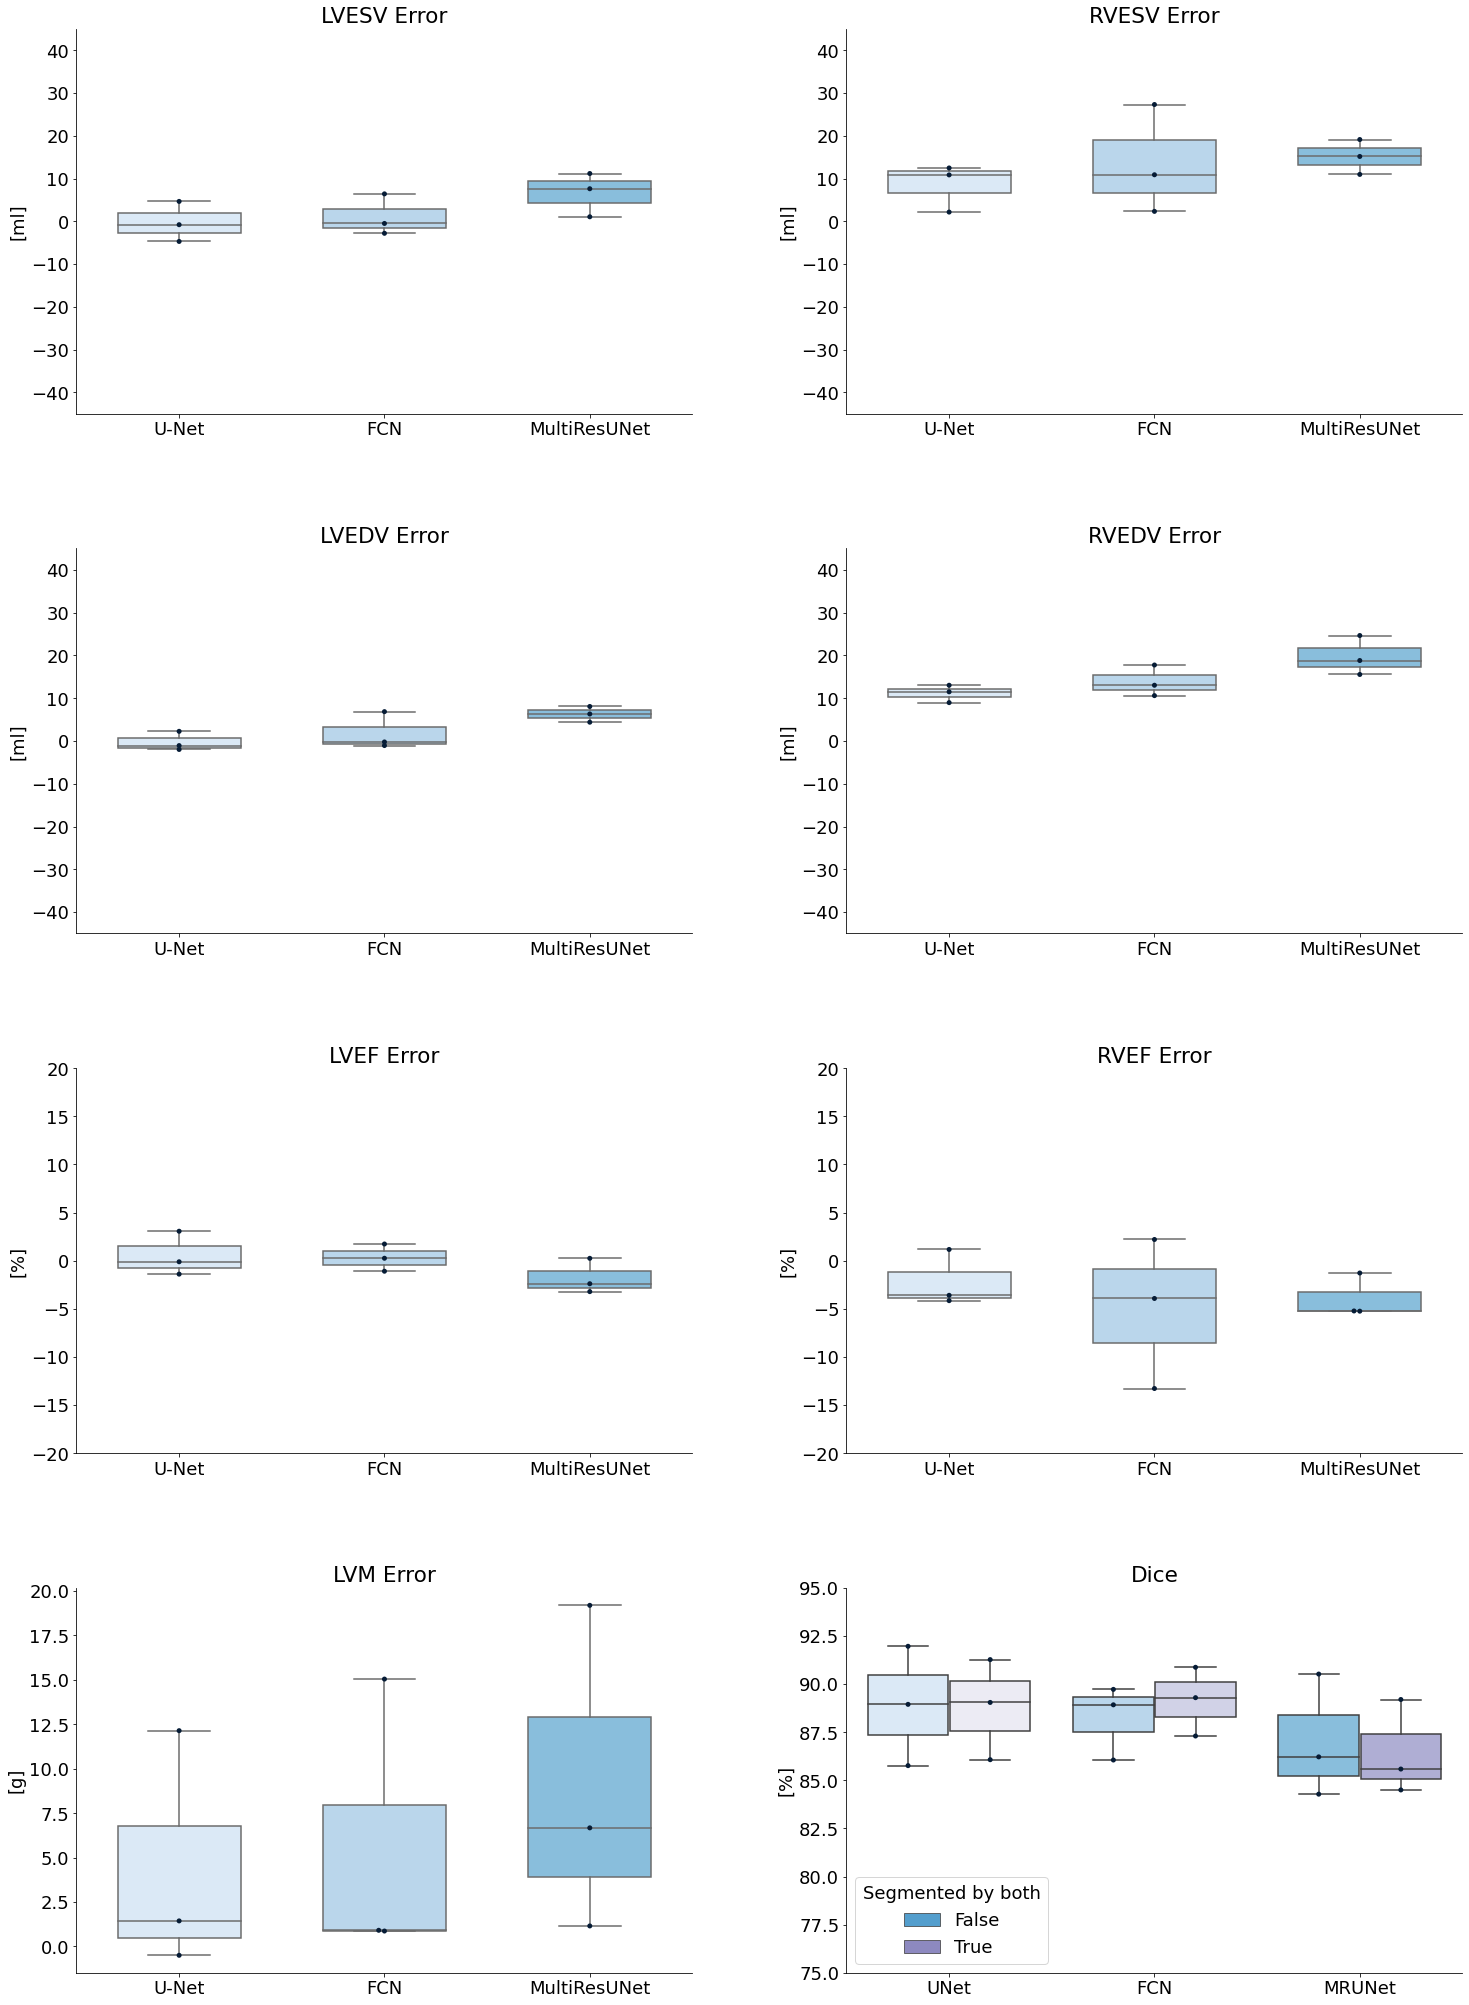

In [6]:
SAX_candlelight_plot(cases1, {'U-Net':cases4, 'FCN':cases2, 'MultiResUNet':cases3}, bp)

## Some random image comparisons

In [ ]:
# Just showing some images
for c1,c2 in zip(cases1, cases4):
    print(c1.case_name, c2.case_name)
    lves1, lved1 = [c for c in c1.categories if 'ES' in c.name][0], [c for c in c1.categories if 'ED' in c.name][0]
    cat2 = [c for c in c2.categories][0]
    esp, edp = lves1.phase, lved1.phase
    for d in range(lves1.nr_slices):
        for p in [esp, edp]:
            print('Slice: ', d, ',  Phase: ', p)
            img1, anno1 = lves1.get_img(d, p), lves1.get_anno(d, p)
            img2, anno2 = cat2 .get_img(d, p), cat2 .get_anno(d, p)
            #fig, axes = plt.subplots(1,5, figsize=(20,10))
            fig, axes = plt.subplots(1,3, figsize=(20,10))
            #for i in range(5): axes[i].imshow(img1,cmap='gray'); axes[i].axis('off')
            for i in range(3): axes[i].imshow(img1,cmap='gray'); axes[i].axis('off')
            anno1.plot_all_contour_outlines(axes[0])
            anno2.plot_all_contour_outlines(axes[1])
            #anno1.plot_cont_comparison(axes[2], anno2, 'lv_endo')
            #anno1.plot_cont_comparison(axes[3], anno2, 'lv_myo' )
            #anno1.plot_cont_comparison(axes[4], anno2, 'rv_endo')
            anno1.plot_cont_comparison(axes[2], anno2, 'lv_myo' )
            anno1.plot_cont_comparison(axes[2], anno2, 'rv_endo')
            fig.tight_layout()
            plt.show()
    break

## Find terrible segmentations

In [ ]:
metric = DiceMetric()
for c1,c2 in zip(cases1, cases4):
    cc = Case_Comparison(c1, c2)
    metric.set_case_comparison(cc)
    dice_dict = metric.calculate_all_vals(True)
    for sop, c in dice_dict.keys():
        if 0 < np.abs(dice_dict[(sop,c)]) < 65:
            print(c, 'dice: ', dice_dict[(sop,c)])
            img   = c1.get_img(sop)
            anno1 = c1.load_anno(sop)
            anno2 = c2.load_anno(sop)
            if not anno1.has_contour(c) or not anno2.has_contour(c): continue
            fig, ax = plt.subplots(1,1,figsize=(10,10))
            ax.imshow(img, interpolation='none', cmap='gray')
            anno1.plot_cont_comparison(ax, anno2, c)
            ax.axis('off')
            plt.show()

## Making metric by phase slice table

In [ ]:
metric_names  = ['dice', 'hd', 'ml diff', 'by reader1', 'by reader2', 'position1', 'position2']
contour_names = ['lv_endo', 'lv_myo', 'rv_endo']
ph_names      = ['ES', 'ED']

column_names  = ['case name', 'reader1', 'reader2', 'slice']
column_names += [cn+' '+p+' '+mn for cn in contour_names for p in ph_names for mn in metric_names]
print(len(column_names))
print(column_names)

In [ ]:
def get_position(case, d, p, cont_name):
    cat  = case.categories[0]
    anno = cat.get_anno(d, p)
    has_cont = anno.has_contour(cont_name)
    if not has_cont:                    return 'outside'
    if has_cont and d==0:               return 'basal'
    if has_cont and d==cat.nr_slices-1: return 'apical'
    prev_has_cont = cat.get_anno(d-1, p).has_contour(cont_name)
    next_has_cont = cat.get_anno(d+1, p).has_contour(cont_name)
    if prev_has_cont and next_has_cont: return 'midv'
    if prev_has_cont and not next_has_cont: return 'apical'
    if not prev_has_cont and next_has_cont: return 'basal'

    
def metrics_phase_slice_table(cases1, cases2, fixed_phase_first_reader=False):
    dsc, hd, mld = DiceMetric(), HausdorffMetric(), mlDiffMetric()
    metrics = [dsc.get_val, hd.get_val, mld.get_val, lambda g1,g2,_: not g1.is_empty, lambda g1,g2,_: not g2.is_empty]
    view = SAX_CINE_View()
    row_dict = {}
    row_counter = 0
    for c1,c2 in zip(cases1, cases2):
        cc = Case_Comparison(c1,c2)
        nr_slices = c1.categories[0].nr_slices
        for sl_nr in range(nr_slices):
            row = [c1.case_name if sl_nr==0 else '', c1.reader_name, c2.reader_name,  sl_nr]
            for cont in contour_names:
                cat_es1, cat_ed1 = view.get_categories(c1, cont)
                cat_es2, cat_ed2 = view.get_categories(c2, cont)
                p_es1, p_ed1 = cat_es1.phase, cat_ed1.phase 
                p_es2, p_ed2 = (p_es1, p_ed1) if fixed_phase_first_reader else (cat_es2.phase, cat_ed2.phase)
                for cat1, cat2 in zip([cat_es1, cat_ed1],[cat_es2, cat_ed2]):
                    p1, p2 = cat1.phase, cat1.phase if fixed_phase_first_reader else cat2.phase
                    dcm = cat1.get_dcm(sl_nr, p1)
                    cont1, cont2 = cat1.get_anno(sl_nr, p1).get_contour(cont), cat2.get_anno(sl_nr, p2).get_contour(cont)
                    for m in metrics: 
                        if p1 is None or p2 is None: row.append('')
                        else: row.append(m(cont1, cont2, dcm))
                    row.extend([get_position(c1, sl_nr, p1, cont), get_position(c2, sl_nr, p2, cont)])
            row_dict['row_'+str(row_counter).zfill(5)] = row
            row_counter +=1 
    df = pandas.DataFrame.from_dict(row_dict, orient='index', columns=column_names)
    return df
table = metrics_phase_slice_table(cases1, cases4, fixed_phase_first_reader=True)

In [ ]:
#display(table)
print(os.path.join(bp, 'metrics_slicephase_table.csv'))
pandas.DataFrame.to_csv(table, os.path.join(bp, 'metrics_slicephase_table_3.csv'), sep=';', decimal=',')

## Metric Plots